In [2]:
import numpy as np

In [120]:
theta = -45
rot= np.vstack([[np.cos(theta * np.pi /180), -np.sin(theta * np.pi /180)], [-np.sin(theta * np.pi /180), np.cos(theta * np.pi /180)]])
print(1/rot, np.sqrt(2))

print(np.linalg.det(1 / rot))

[[1.41421356 1.41421356]
 [1.41421356 1.41421356]] 1.4142135623730951
-6.280369834735089e-16


In [1]:
import geological_segmentation as geoseg
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from SimPEG.electromagnetics.static import resistivity as dc, utils as dcutils
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.stats import norm
import scipy.sparse as sp
from sklearn.mixture import GaussianMixture
import copy
# setup the GMMRF
from scipy import spatial, linalg
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator
from PIL import Image
from scipy import stats
from matplotlib import cm
from scipy.special import logsumexp
from sklearn.mixture._gaussian_mixture import (
    _compute_precision_cholesky,
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import datetime
import warnings
import random

# Python Version
import sys
print(sys.version)

# Reproducible science
seed = 12345
np.random.seed(seed)

from pathlib import Path

from SimPEG.regularization import (

    PGIsmallness,
)

from scipy.ndimage import laplace

class plot_mref(directives.InversionDirective):

    mesh = None
    
    def initialize(self):
        self.start = 0
        # self.endIter()
    
    def endIter(self):
        # plot
        meshCore = self.mesh
        # predicted = self.invProb.reg.gmmref.predict(self.opt.xc.reshape(-1, 1))
        fig,ax = plt.subplots(3,1,figsize=(15,5))
        mm = meshCore.plot_image(
            self.opt.xc, ax=ax[0],
            # clim=[-np.log(250),-np.log(10),],
            # clim=[0,500],
            pcolor_opts={'cmap':'Spectral'}
        )
        # fig,ax = plt.subplots(1,1,figsize=(15,5))
        mm2 = meshCore.plot_image(
            1 / np.exp(self.invProb.reg.objfcts[0].mref), ax=ax[1],
            # clim=[-np.log(250),-np.log(10),],
            clim=[0,500],
            pcolor_opts={'cmap':'Spectral'}
        )
        # ax.set_xlim([-750,750])
        # ax.set_ylim([-250,0])
        # fig,ax = plt.subplots(1,1,figsize=(15,5))
        # mmpred = meshCore.plot_image(
        #    predicted, ax=ax[3],
        #     # clim=[-np.log(250),-np.log(10),],
        #     pcolor_opts={'cmap':'Spectral'}
        # )
        
        #plt.colorbar(mm[0])
        # utils.plot2Ddata(
        #     meshCore.gridCC,1 / np.exp(mtrue[actcore]),nx=500,ny=500,
        #     contourOpts={'alpha':0},
        #     clim=[0,500],
        #     ax=ax[0],
        #     level=True,
        #     ncontour=2,
        #     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
        #     method='nearest'
        # )

        ax[2].hist(1 / np.exp(self.opt.xc), 100)
        # ax[2].set_aspect(1)

        # ax[0].set_ylim([-15,0])
        # ax[0].set_xlim([-15,15])
        ax[0].set_aspect(1)
        # ax[1].set_ylim([-15,0])
        # ax[1].set_xlim([-15,15])
        ax[1].set_aspect(1)
        fig.savefig(f'./iterations/{self.start}.png')
        np.save(f'./iterations/model_{self.start}.npy', self.opt.xc)
        plt.show()
        self.start += 1



3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]



  TensorMesh: 13,651 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    187     -2,338.70      2,338.70      5.00    648.73    1.50
   y     73     -2,233.70          2.50      5.00    648.73    1.50




/tmp/ipykernel_173264/3763415230.py:44: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  mm1 = mesh.plotImage(model, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})
/home/juanito/mambaforge/envs/jresearch/lib/python3.11/site-packages/discretize/utils/code_utils.py:313: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)
/tmp/ipykernel_173264/3763415230.py:65: FutureWarning: ExtractCoreMesh has been deprecated, please use extract_core_mesh. It will be removed in version 0.19.0 of SimPEG.
  actcore,  meshCore = utils.mesh_utils.ExtractCoreMesh(xyzlim, mesh)
/tmp/ipykernel_173264/3763415230.py:69: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  mm = meshCore.plot_image(
/home/juanito/mambaforge/envs/jresearch/lib/python3.11/site-packages/SimPEG/electromagnetics/static/resistivity/simulation_2d.py:756: Runtime

0.05000147715874263
20.27636899645555
0.06860442611833567
0.20936297584738828


Text(0.5, 1.0, 'Relative Error ($\\frac{\\sigma^{2}}{d_{obs}}$)')

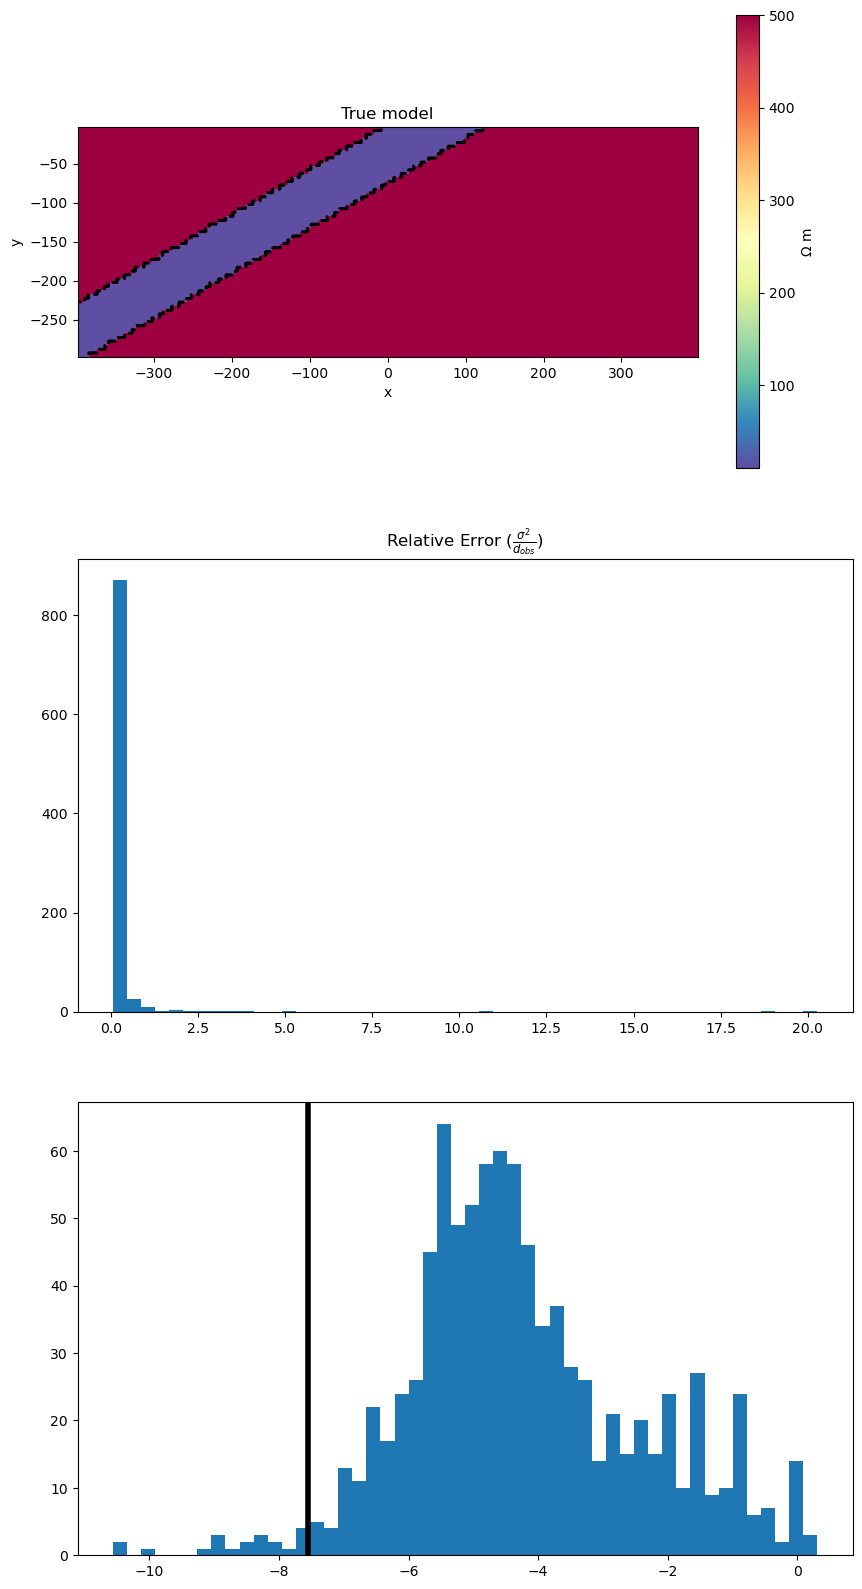

In [2]:
# -------------------------------------------------------------------------------------------------

# create a 2d mesh for a dc simulation

#

#2D mesh
csx,  csy,  csz = 5.,  5.,  5.
# Number of core cells in each direction
ncx,  ncz = 163,  61
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

print(mesh)

# -----------------------------------------------------------------------

# create a synthetic model for a dc simulation

#

model = 3 * np.ones(mesh.nC, dtype='int64')

# divide domain by  45* fault at 100 m
fault_function = lambda x, slope, shift: slope * x + shift

# Dike 30*
dike0 = mesh.gridCC[:,1] > fault_function(
    mesh.gridCC[:,0], np.tan(30 * np.pi / 180), -75)
dike1 = mesh.gridCC[:,1] < fault_function(
    mesh.gridCC[:,0], np.tan(30 * np.pi / 180), 0)
dike = np.logical_and(dike0,dike1)

model[dike]=4

# plot
fig,ax = plt.subplots(3, 1,figsize=(10,20))
mm1 = mesh.plotImage(model, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})

ax[0].set_xlim([-1000,1000])
ax[0].set_ylim([-250,0])
# ax[0].set_aspect(2)
# plt.colorbar(mm1[0])


# define conductivities
res_true = np.ones(mesh.nC)
res_true[model==3]= 500
res_true[model==4]= 10

cond_true = 1./res_true

mtrue = np.log(cond_true)

xmin, xmax = -400., 400.
ymin, ymax = -300., 0.
zmin, zmax = 0, 0
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = utils.mesh_utils.ExtractCoreMesh(xyzlim, mesh)
actind = np.ones_like(actcore)

# plot
mm = meshCore.plot_image(
    
    1/(cond_true)[actcore],
    ax=ax[0],
    pcolorOpts={'cmap':'Spectral_r'}

)

utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)
#plt.gca().set_ylim([-200,0])
ax[0].set_aspect(1)
plt.colorbar(mm[0], label=r'$\Omega$ m')
ax[0].set_title('True model')

xmin, xmax = -350., 350.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
srclist = []

for dipole in np.linspace(25,250,10):
    
    survey1 = dcutils.generate_dcip_survey(
        
        endl, survey_type="pole-dipole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )

    # print(dipole)

    survey2 = dcutils.generate_dcip_survey(
        
        endl, survey_type="dipole-pole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )
    
    srclist +=(survey1.source_list)
    srclist +=(survey2.source_list)

survey = dc.Survey(srclist)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = maps.ExpMap(mesh)
mapactive = maps.InjectActiveCells(
    
    mesh=mesh,
    indActive=actcore,
    valInactive=-np.log(100)

)
mapping = expmap * mapactive
simulation = dc.Simulation2DNodal(
    
    mesh, 
    survey=survey, 
    sigmaMap=mapping,
    solver=Solver,
    nky=8

)

# -----------------------------------------------------------------------

# create synthetic data and view psuedo-section

#

relative_measurement_error = 0.05
dc_data = simulation.make_synthetic_data(
    
    mtrue[actcore],
    relative_error=relative_measurement_error,
    noise_floor=3e-3,
    force=True,
    add_noise=True,

)

dc_data.noise_floor = np.quantile(np.abs(dc_data.dobs), 0.02)

relative_error_list = (np.abs(dc_data.standard_deviation/dc_data.dobs))
print(relative_error_list.min())
print(relative_error_list.max())
print(np.median(relative_error_list))
print(relative_error_list.mean())
ax[1].hist(relative_error_list, 50)
ax[2].hist(np.log(np.abs(dc_data.dobs)), 50)
ax[2].axvline(np.log(np.quantile(np.abs(dc_data.dobs), 0.02)), color='k', linewidth=4)
ax[1].set_title(r'Relative Error ($\frac{\sigma^{2}}{d_{obs}}$)')

1910.7929554219065 0.003106576526681338 166.70025079551905


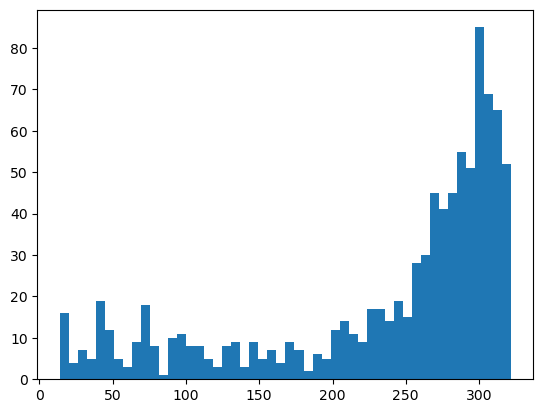

In [3]:
print(1 / dc_data.noise_floor[0], np.quantile(dc_data.dobs, 0.55), dcutils.apparent_resistivity_from_voltage(survey, dc_data.dobs).mean())
plt.hist(1 / (np.abs(dc_data.dobs * 0.05) + np.quantile(dc_data.dobs, 0.55)), 50)
# plt.hist(dmis.W.diagonal(), 50)
# plt.hist(dc_data.standard_deviation + dc_data.noise_floor)

plt.show()

adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting
adjusting


/tmp/ipykernel_173264/201069297.py:118: UserWarning: 'everyIter' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'every_iteration'.
  updateSensW = directives.UpdateSensitivityWeights(threshold=5e-1, everyIter=False)
/tmp/ipykernel_173264/201069297.py:118: UserWarning: 'threshold' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'threshold_value'.
  updateSensW = directives.UpdateSensitivityWeights(threshold=5e-1, everyIter=False)



                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        


/home/juanito/mambaforge/envs/jresearch/lib/python3.11/site-packages/SimPEG/directives/directives.py:332: UserWarning: There is no PGI regularization. Smallness target is turned off (TriggerSmall flag).
  getattr(r, ruleType)()


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e-01  7.00e+03  2.36e+03  7.23e+03    1.18e+02      0              
geophys. misfits: 6978.4 (target 460.0 [False])


/tmp/ipykernel_173264/2563674460.py:71: FutureWarning: reference_model.mref has been deprecated, please use reference_model. It will be removed in version 0.19.0 of SimPEG.
  1 / np.exp(self.invProb.reg.objfcts[0].mref), ax=ax[1],


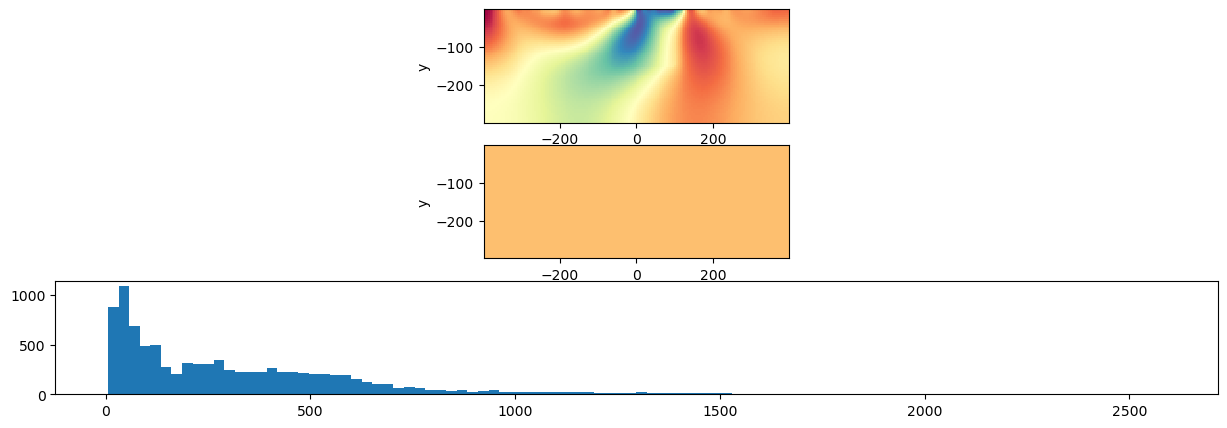

   1  1.00e-01  6.98e+03  2.36e+03  7.21e+03    1.08e+02      0              
geophys. misfits: 6965.8 (target 460.0 [False])


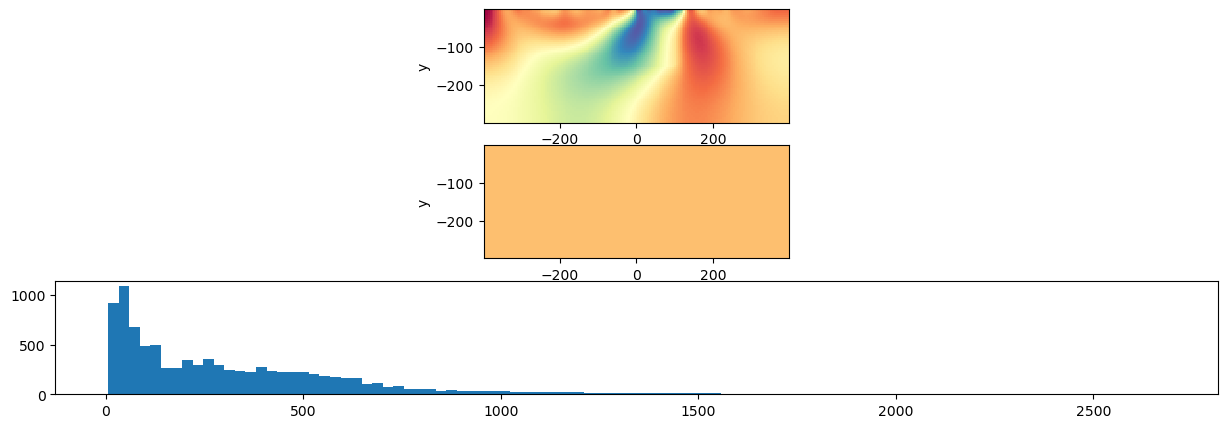

   2  2.00e-02  6.97e+03  2.36e+03  7.01e+03    1.10e+02      0              
geophys. misfits: 6920.6 (target 460.0 [False])


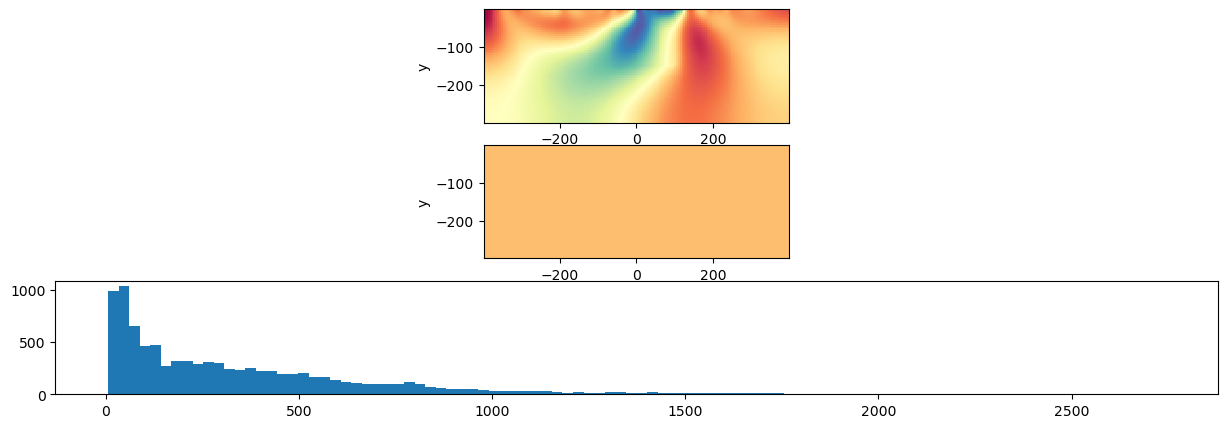

   3  2.00e-02  6.92e+03  2.37e+03  6.97e+03    1.06e+02      0   Skip BFGS  
geophys. misfits: 6897.8 (target 460.0 [False])


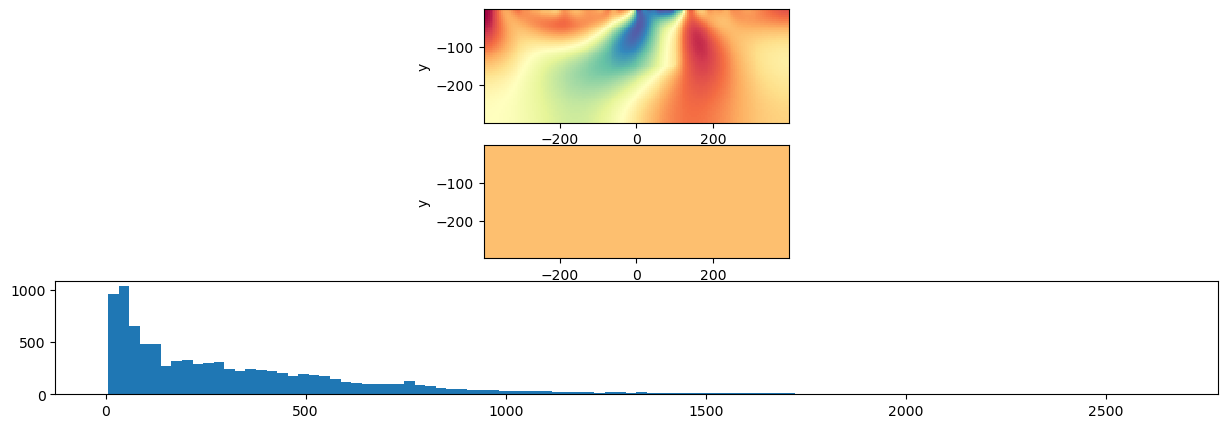

   4  4.00e-03  6.90e+03  2.37e+03  6.91e+03    9.81e+01      0              
geophys. misfits: 6884.6 (target 460.0 [False])


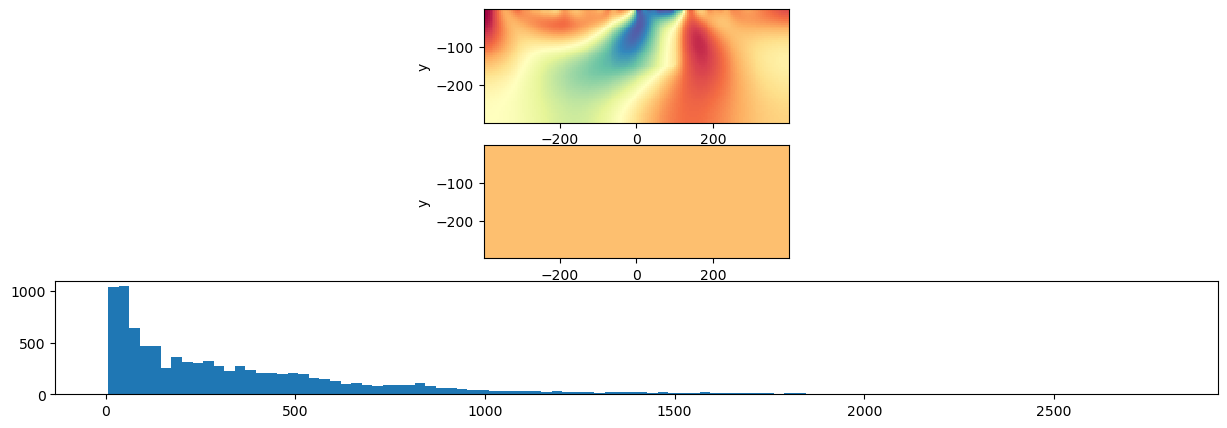

   5  4.00e-03  6.88e+03  2.37e+03  6.89e+03    9.66e+01      0              
geophys. misfits: 6860.8 (target 460.0 [False])


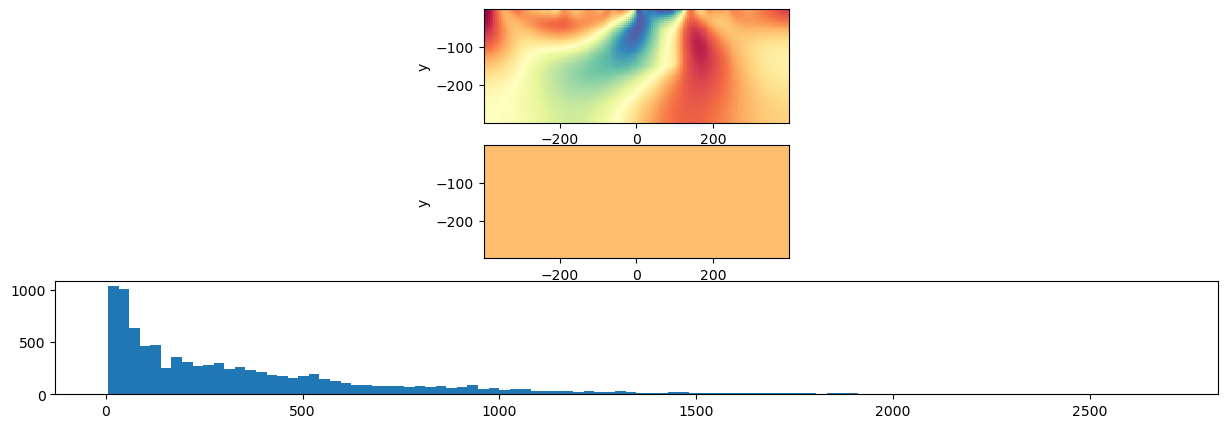

   6  8.00e-04  6.86e+03  2.38e+03  6.86e+03    9.16e+01      0              
geophys. misfits: 6844.9 (target 460.0 [False])


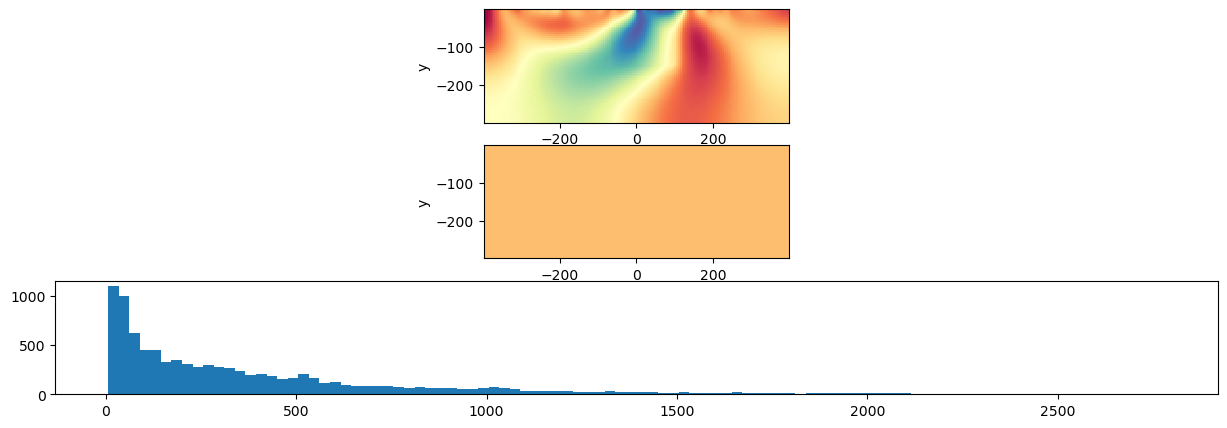

   7  8.00e-04  6.84e+03  2.38e+03  6.85e+03    8.62e+01      0              
geophys. misfits: 6834.2 (target 460.0 [False])


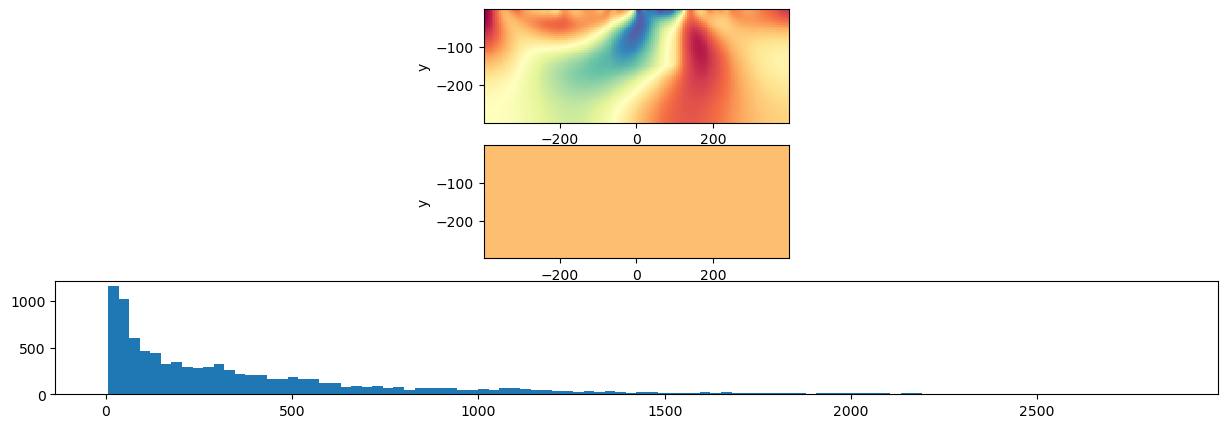

   8  1.60e-04  6.83e+03  2.39e+03  6.83e+03    8.21e+01      0              
geophys. misfits: 6829.6 (target 460.0 [False])


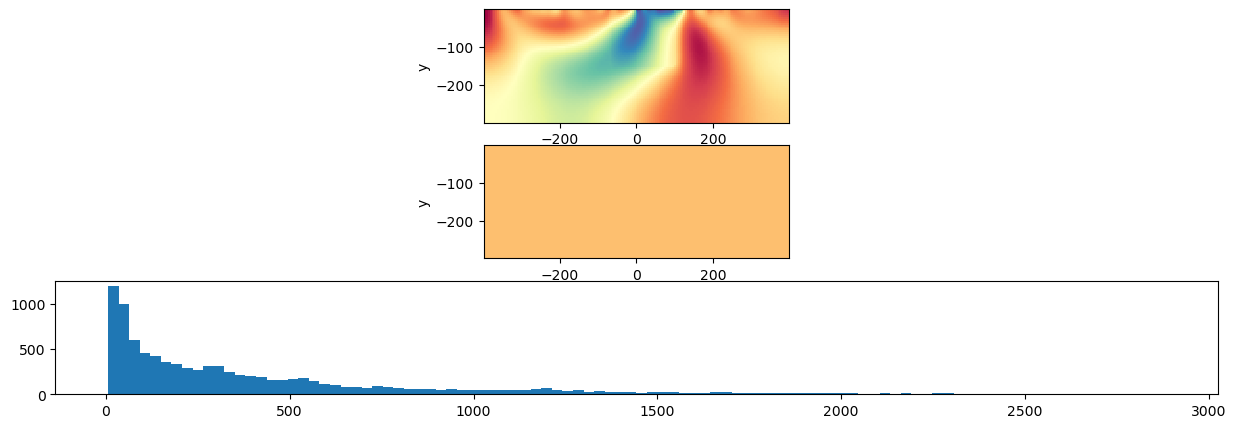

   9  1.60e-04  6.83e+03  2.39e+03  6.83e+03    8.21e+01      0              
geophys. misfits: 6827.1 (target 460.0 [False])


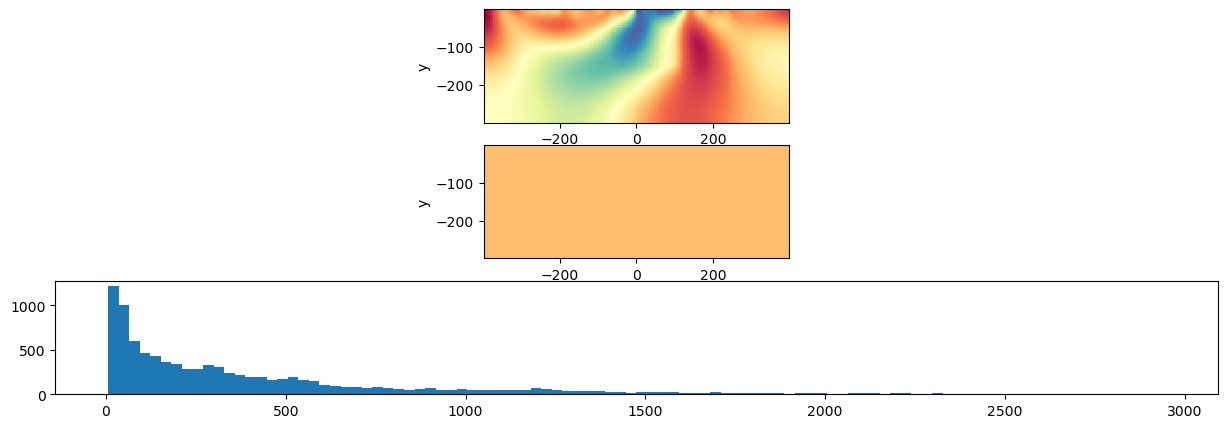

  10  3.20e-05  6.83e+03  2.39e+03  6.83e+03    7.85e+01      0              
geophys. misfits: 6825.7 (target 460.0 [False])


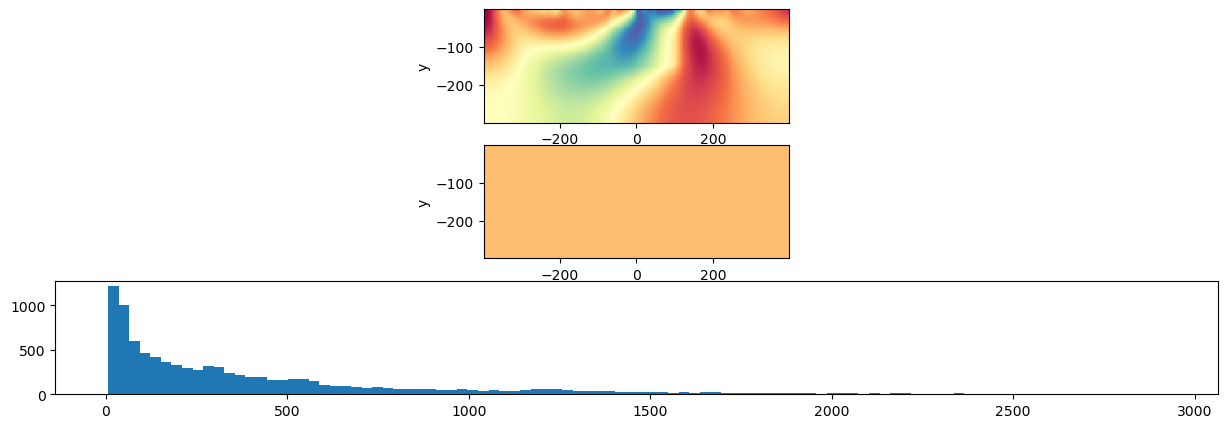

  11  3.20e-05  6.83e+03  2.39e+03  6.83e+03    8.02e+01      0              
geophys. misfits: 6815.9 (target 460.0 [False])


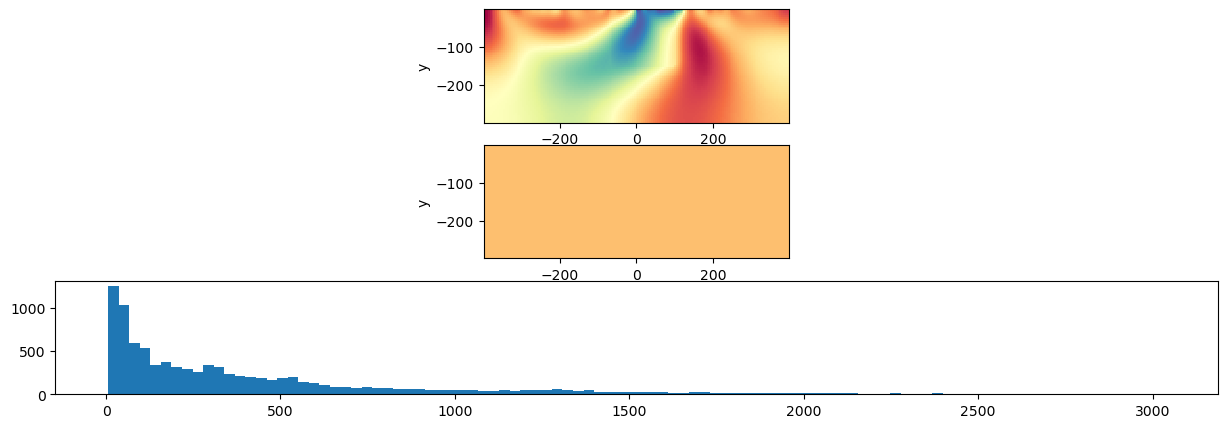

  12  6.40e-06  6.82e+03  2.39e+03  6.82e+03    8.53e+01      0              
geophys. misfits: 6806.9 (target 460.0 [False])


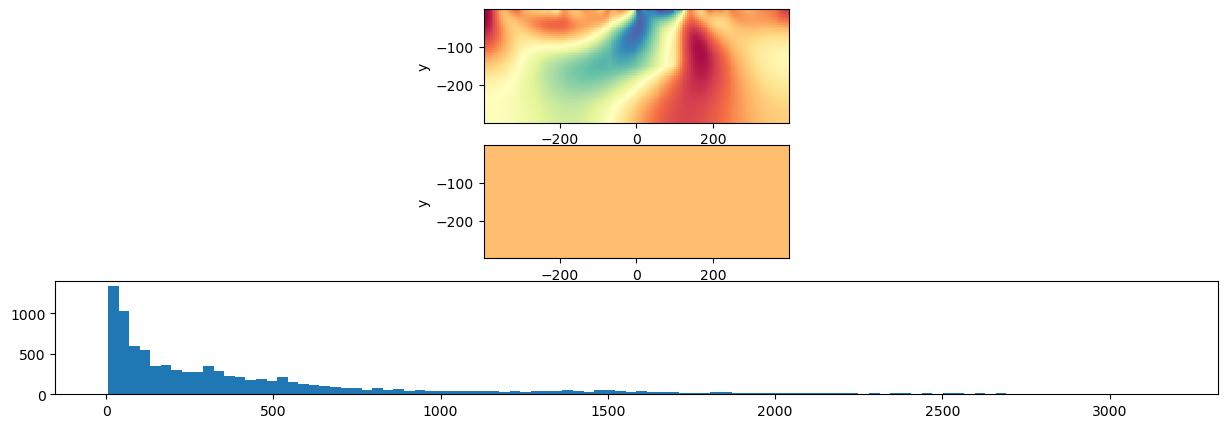

  13  6.40e-06  6.81e+03  2.40e+03  6.81e+03    7.66e+01      0              
geophys. misfits: 6797.7 (target 460.0 [False])


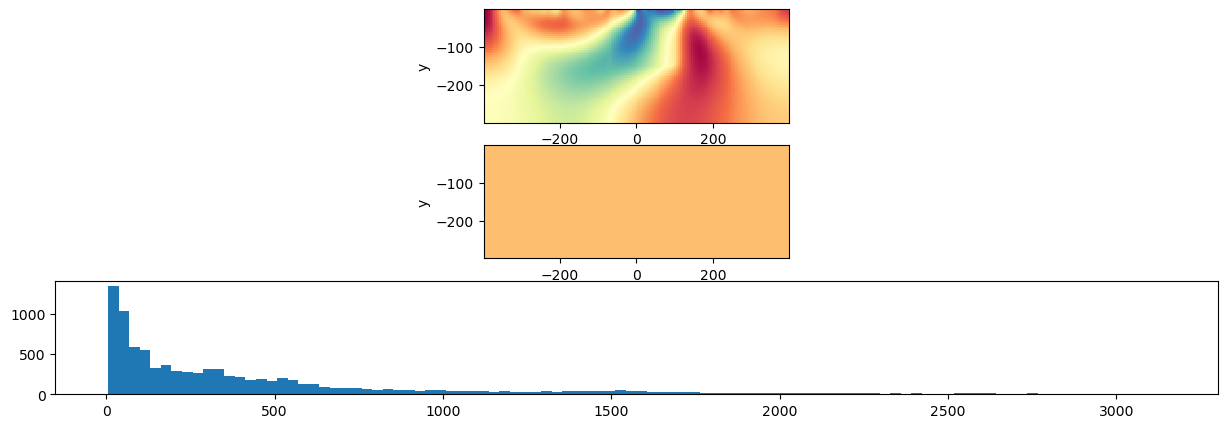

  14  1.28e-06  6.80e+03  2.40e+03  6.80e+03    6.79e+01      0   Skip BFGS  
geophys. misfits: 6792.6 (target 460.0 [False])


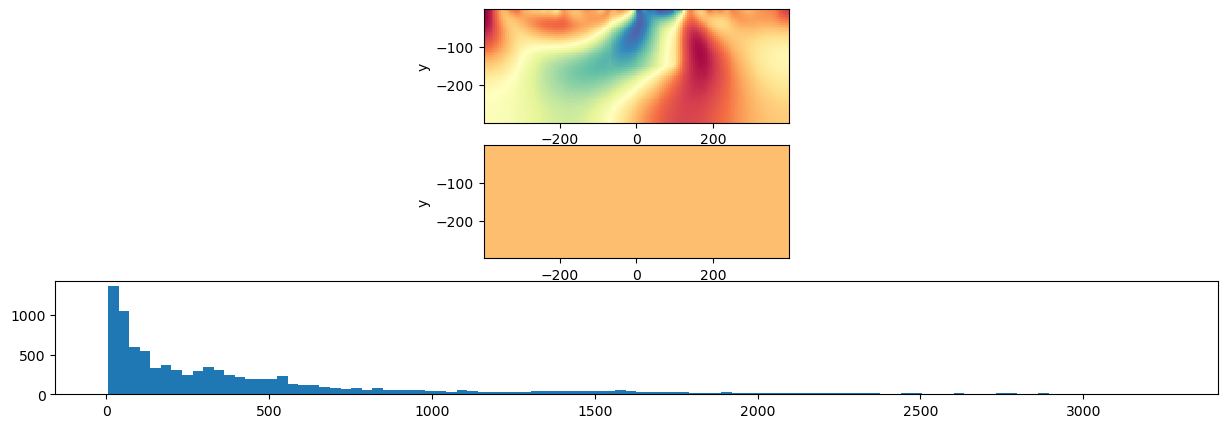

  15  1.28e-06  6.79e+03  2.40e+03  6.79e+03    6.96e+01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 5.1560e+00 <= tolF*(1+|f0|) = 7.2333e+02
1 : |xc-x_last| = 1.5265e+00 <= tolX*(1+|x0|) = 5.1726e+01
0 : |proj(x-g)-x|    = 6.9604e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 6.9604e+01 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =      15    <= iter          =     15
------------------------- DONE! -------------------------


In [3]:
# --------------------------------------------------------------------------

# setup the inversion

#
# theta = -45
# rot= np.vstack([[np.cos(theta * np.pi /180), -np.sin(theta * np.pi /180)], [np.sin(theta * np.pi /180), np.cos(theta * np.pi /180)]])


dmis = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)
# dmis.w = 1 / np.abs(dc_data.dobs * 0.05 + np.quantile(np.abs(dc_data.dobs), 0.1))
# m0 = np.log(1/dcutils.apparent_resistivity_from_voltage(survey, dc_data.dobs).mean()) * np.ones(mapping.nP)
m0 = np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/iterations/model_6.npy")
# Create the regularization with GMM information
idenMap = maps.IdentityMap(nP=m0.shape[0])
wires = maps.Wires(('m', m0.shape[0]))

# load mask
rot_mask = np.load('rotation_block_mask.npy')

# set the regularization
alphas = np.ones((meshCore.n_cells, meshCore.dim))
# alphas[rot_mask] = [125, 25]
# alphas[meshCore.cell_centers[:, 1] < 0.5] = [125, 25]
sqrt2 = np.sqrt(2)
# reg_cell_dirs = 1 / np.array([[sqrt2, -sqrt2], [sqrt2, sqrt2],])
# lets just assign them to the dip structure
reg_cell_dirs = [np.identity(2) for _ in range(meshCore.nC)]

# lets just assign them to the dip structure
# reg_cell_dirs = [1 / np.array([[sqrt2, -sqrt2], [-sqrt2, -sqrt2],]) for _ in range(meshCore.nC)]
# print(reg_cell_dirs)
# # lets expand the area we want to
# # Dike 45*
# dike00 = mesh.gridCC[:,1] > fault_function(mesh.gridCC[:,0],1, 50)
# dike01 = mesh.gridCC[:,1] < fault_function(mesh.gridCC[:,0],1, 255)
# dike_dir_reg = np.logical_and(dike00,dike01)

# # reg model
# reg_model = model.copy()

# reg_model[dike_dir_reg]=4

# # cos = np.cos(140*np.pi / 180) * 2
# # sin = np.sin(140*np.pi / 180) * 2

for ii in range(meshCore.nC):

    if rot_mask[ii] == 1:
        print('adjusting')
        # reg_cell_dirs[ii] = np.array([[cos, -sin], [sin, cos],])
        reg_cell_dirs[ii] = 1 / np.array([[sqrt2, -sqrt2], [-sqrt2, -sqrt2],])
        alphas[ii] = [125, 25]

# reg_mean = GeologicalSegmentation(
#     meshCore, 
#     reg_dirs=None,
#     ortho_check=False,
#     segmentation_model=segmentor
# )
reg_1storder = regularization.SmoothnessFullGradient(
    meshCore, 
    reg_dirs=reg_cell_dirs,
    alphas=alphas,
    ortho_check=True,
    reference_model=np.log(1/dcutils.apparent_resistivity_from_voltage(survey, dc_data.dobs).mean()) * np.ones(mapping.nP)
)

reg_small = regularization.Smallness(mesh=meshCore)

# # Weighting
reg_org = regularization.WeightedLeastSquares(
    mesh, 
    active_cells=actcore,
    mapping=idenMap,
    reference_model=m0
)

reg_mean = reg_1storder
# reg_mean = reg_org
# reg_mean.alpha_s = 1e-4
# reg_mean.alpha_x = 1
# reg_mean.alpha_y = 1
# # reg_mean.mrefInSmooth = True
# reg_mean.approx_gradient = True


# Optimization
opt = optimization.ProjectedGNCG(maxIter=15, upper=np.inf, lower=-np.inf, tolCG=1E-5, maxIterLS=20, )
opt.remember('xc')

# Set the inverse problem
invProb = inverse_problem.BaseInvProblem(dmis,  reg_mean,  opt)

# Inversion directives
# betaIt = directives.PGI_BetaAlphaSchedule(
#     verbose=True, coolingFactor=3.,
#     warmingFactor=1., tolerance=0.05,
#     progress=0.1
# )
betaIt = directives.BetaSchedule(coolingFactor=5, coolingRate=2)
targets = directives.MultiTargetMisfits(
    TriggerSmall=True,
    TriggerTheta=False,
    verbose=True,
)
MrefInSmooth = directives.PGI_AddMrefInSmooth(verbose=True,  wait_till_stable=True, tolerance=0.0)
# petrodir = PGIUpdateParameters(
#     update_covariances=True,
#     kappa = 1e8,
#     nu = 1e8,
#     update_rate = 2,
#     update_reference_model=False
#     )
# update_sam = update_segmentation_neighbours()
plot_iter_mref = plot_mref()
plot_iter_mref.mesh = meshCore
updateSensW = directives.UpdateSensitivityWeights(threshold=5e-1, everyIter=False)
update_Jacobi = directives.UpdatePreconditioner()
# save_pgi = SavePGIOutput('./pgi_param')
invProb.beta = 1e-1
inv = inversion.BaseInversion(invProb,
                            directiveList=[
                                            # updateSensW,
                                            #  update_sam,
                                            #  petrodir,
                                            targets, betaIt,
                                            #  MrefInSmooth,
                                            plot_iter_mref,
                                            #  save_pgi,
                                            # update_Jacobi,
                                            ])

# Run!

mcluster = inv.run(m0)

# np.save("rotated_model_dip.npy", mcluster)
# np.save("true_model_dip.npy", mtrue)
# # mcluster = np.load("rotated_model.npy")

# # plot
# mm = meshCore.plot_image(
    
#     1/(np.exp(mcluster)),
#     ax=ax[2],
#     clim=[0, 500],
#     pcolorOpts={'cmap':'Spectral_r'}

# )

# utils.plot2Ddata(

#     meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
#     contourOpts={'alpha':0},
#     #clim=[0,5],
#     ax=ax[2],
#     level=True,
#     ncontour=2,
#     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
#     method='nearest'
    
# )
# #plt.gca().set_ylim([-200,0])
# ax[2].set_aspect(1)
# plt.colorbar(mm[0], label=r'$\Omega$ m')
# ax[2].set_title('Rotated gradient recovered model')


In [ ]:
from scipy.sparse import diags
dip_model = np.load(r"/home/juanito/git/jresearch/geological_segmentation/iterations/model_6.npy")


theta = 45 * np.pi / 180

# X term ------------------------------------------------------------------------------
alpha_rot_x = alphas[:, 0] * np.cos(theta)**2 + alphas[:, 1] * np.sin(theta)**2
average_cell_to_face_x = meshCore.average_cell_to_face[: meshCore.nFx]

a = meshCore.face_x_areas
v = average_cell_to_face_x @ meshCore.cell_volumes
cell_gradient_x = sp.diags(a / v) @ meshCore.stencil_cell_gradient_x

r = cell_gradient_x @ (reg_mean.mapping * (reg_mean._delta_m(dip_model)))

# M_f = meshCore.get_face_inner_product(alpha_rot)
bx = average_cell_to_face_x @ alpha_rot_x

# phix = r[:, None].T @ diags(bx) @ r[:, None]
# print(phix, r[:, None].shape, bx.shape)

# Y term ------------------------------------------------------------------------------
alpha_rot_y = alphas[:, 0] * np.sin(theta)**2 + alphas[:, 1] * np.cos(theta)**2
average_cell_to_face_y = meshCore.average_cell_to_face[
    meshCore.nFx:(meshCore.nFx + meshCore.nFy)
]

a = meshCore.face_y_areas
v = average_cell_to_face_y @ meshCore.cell_volumes
cell_gradient_y = sp.diags(a / v) @ meshCore.stencil_cell_gradient_y

r = cell_gradient_y @ (reg_mean.mapping * (reg_mean._delta_m(dip_model)))

# M_f = meshCore.get_face_inner_product(alpha_rot)
by = average_cell_to_face_y @ alpha_rot_y

# phiy = r[:, None].T @ diags(by) @ r[:, None]


# XY term ------------------------------------------------------------------------------
alpha_rot_xy = (alphas[:, 0] - alphas[:, 1]) * np.sin(theta) * np.cos(theta)
print(phiy, r[:, None].shape, by.shape, alpha_rot_xy.shape, meshCore.nC)
# average_cell_to_face_xy = meshCore.average_cell_to_face[:(meshCore.nFx + meshCore.nFy)
# ]

ax = meshCore.face_x_areas
vx = average_cell_to_face_x @ meshCore.cell_volumes
cell_gradient_x = sp.diags(ax / vx) @ meshCore.stencil_cell_gradient_x

ay = meshCore.face_y_areas
vy = average_cell_to_face_y @ meshCore.cell_volumes
cell_gradient_y = sp.diags(ay / vy) @ meshCore.stencil_cell_gradient_y

rx = cell_gradient_x @ (reg_mean.mapping * (reg_mean._delta_m(dip_model)))
ry = cell_gradient_y @ (reg_mean.mapping * (reg_mean._delta_m(dip_model)))

# M_f = meshCore.get_face_inner_product(alpha_rot)
# bxy1 = average_cell_to_face_x @ alpha_rot_xy
# bxy2 = average_cell_to_face_y @ alpha_rot_xy
print(cell_gradient_x.shape, cell_gradient_y.shape, diags(alpha_rot_xy).shape)
# phixy = rx[:, None].T @ diags(alpha_rot_xy) @ ry[:, None] #  + ry[:, None].T @ diags(bxy2) @ rx[:, None]
# print(phixy)

# a1 = sp.kron(average_cell_to_face_y, average_cell_to_face_x)

# construct whole thing
Gxz1 = cell_gradient_x @ diags(alpha_rot_xy) @ cell_gradient_y.T # + cell_gradient_y @ diags(alpha_rot_xy) @ cell_gradient_x.T
print(Gxz1.shape) 


[[60.96826673]] (9540, 1) (9540,) (9381,) 9381
(9440, 9381) (9540, 9381) (9381, 9381)
(9440, 9540)


In [ ]:
# a1 = sp.kron(by, bx)
print(bx.shape)

(1, 90057600)


In [18]:
G = reg_1storder.cell_gradient
W = reg_1storder.W

r = G @ (reg_1storder.mapping * (reg_1storder._delta_m(dip_model)))
print(G.shape, W.shape, r.shape, bx.shape, 18980 / 9440)
# fig, ax = plt.subplots(1,1)
# mm = meshCore.plot_image(
    
#     mcluster,
#     ax=ax,
#     # clim=[0, 500],
#     pcolorOpts={'cmap':'Spectral_r'}

# )

# plt.colorbar(mm[0], label=r'$\Omega$ m')
# plt.show()

(18980, 9381) (18980, 18980) (18980,) (9440,) 2.010593220338983


/tmp/ipykernel_202642/3065961996.py:14: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  mm = meshCore.plot_image(


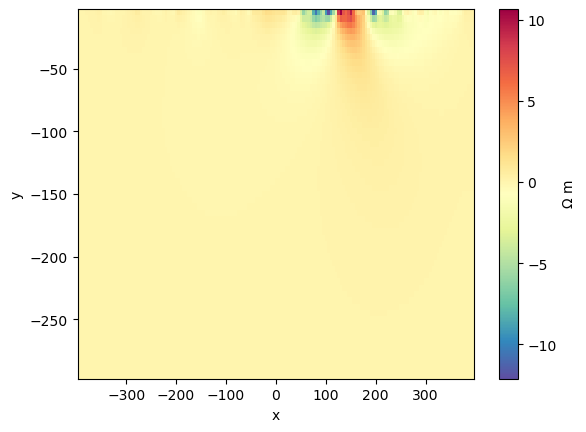

3732145.829043437
1013.2123669344991


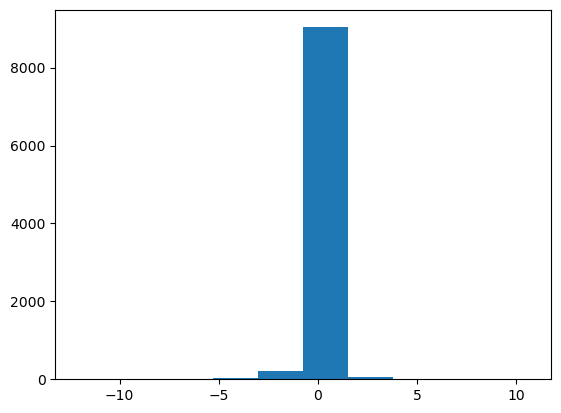

In [30]:
# dip_model = np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/iterations/model_1.npy")

mcluster = reg_mean.deriv(dip_model)
# # print(reg_mean.W)
# G = reg_mean.cell_gradient
# M_f = reg_mean.W
# r = G @ (reg_mean.mapping * (reg_mean._delta_m(dip_model)))
# print((r @ M_f @ r).min())
# plt.hist(r @ M_f @ r)
# return 0.5 * r @ M_f @ r
# print(reg_org._W)

fig, ax = plt.subplots(1,1)
mm = meshCore.plot_image(
    
    mcluster,
    ax=ax,
    # clim=[0, 500],
    pcolorOpts={'cmap':'Spectral_r'}

)

plt.colorbar(mm[0], label=r'$\Omega$ m')
plt.show()

# fig, ax = plt.subplots(1,1)
# mm = meshCore.plot_image(
    
#     # reg_mean.deriv(dip_model),
#     reg_1storder._anis_alpha[:, 0],
#     ax=ax,
#     # clim=[-0.08, 0.08],
#     pcolorOpts={'cmap':'Spectral_r'}

# )

# plt.colorbar(mm[0], label=r'$\Omega$ m')
# plt.show()

print(reg_org(dip_model))
print(reg_mean(dip_model))

plt.hist(mcluster)
plt.show()

In [146]:
reg_org.objfcts[0].deriv(dip_model)

array([-159.12927246, -159.13009532, -159.13156349, ..., -163.47652923,
       -162.89668526, -162.62405472])

In [107]:
import numpy as np

def are_vectors_orthonormal(vector1, vector2, tolerance=1e-10):
    # Check if the vectors are orthogonal
    dot_product = np.dot(vector1, vector2)
    is_orthogonal = np.abs(dot_product) < tolerance

    # Check if the vectors are normalized
    magnitude_vector1 = np.linalg.norm(vector1)
    magnitude_vector2 = np.linalg.norm(vector2)
    is_normalized = np.abs(magnitude_vector1 - 1.0) < tolerance and np.abs(magnitude_vector2 - 1.0) < tolerance

    # Return True if both conditions are satisfied
    return is_orthogonal and is_normalized

# Example usage:
vector_a = np.array([sqrt2, -sqrt2])
vector_b = np.array([sqrt2, sqrt2])

if are_vectors_orthonormal(1/vector_a, 1/vector_b):
    print("The vectors are orthonormal.")
else:
    print("The vectors are not orthonormal.")
print(sqrt2, 1/sqrt2)

The vectors are orthonormal.
1.4142135623730951 0.7071067811865475


In [3]:
dip_model = np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/iterations/model_6.npy")

segmentor = geoseg.SamClassificationModel(
    meshCore,
    segmentation_model_checkpoint=r"/home/juanito/Documents/trained_models/sam_vit_h_4b8939.pth"
)

masks = segmentor.fit(dip_model)

mask 0 vote total: 0
mask 1 vote total: 1
mask 2 vote total: 0
mask 3 vote total: 0
[]
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 4.33734940e-02 2.91566265e-01]
 [0.00000000e+00 4.33734940e-07 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.91566265e-06 0.00000000e+00 1.00000000e+00]]


In [59]:
segmentor.union_matrix[:, 0]

# background_index = segmentor.union_matrix[:, 0] == 1 | 0
background_index = np.where((segmentor.union_matrix[:, 0] == 1) | (segmentor.union_matrix[:, 0] == 0))
# objects_index = segmentor.union_matrix[:, 0] == 0

filtered_union = segmentor.union_matrix[background_index[0], :]
filtered_union = filtered_union[:, background_index[0]]


In [79]:
# masks[7]['bbox']
# type(background_index[0][0])
new_segmentations = [ segmentor.segmentations[seg] for seg in background_index[0]]
print(new_segmentations[0]['bbox'])

[0, 0, 58, 158]


In [26]:
meshCore.cell_centers[48]

array([-155., -295.])

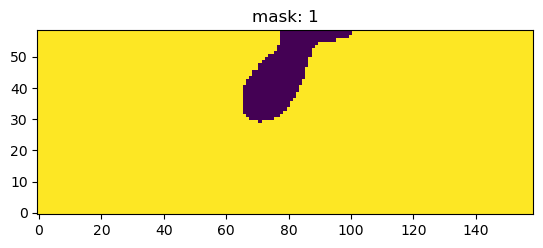

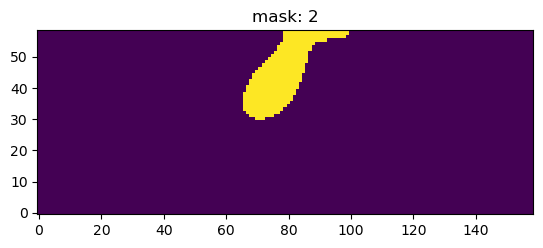

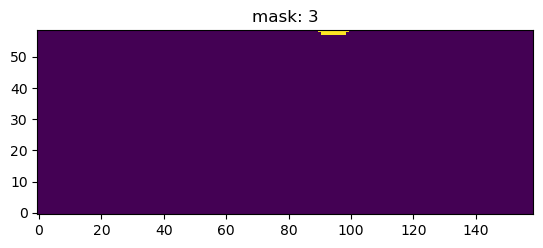

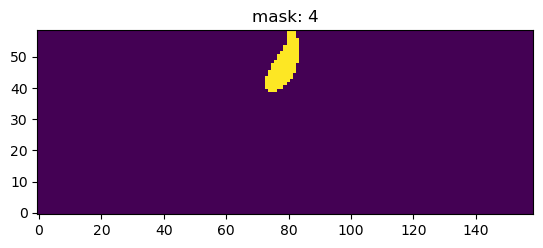

7


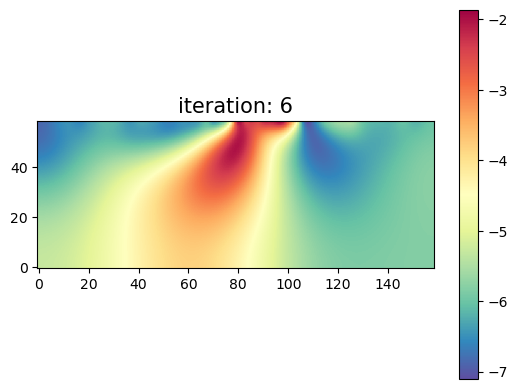

In [4]:
results = masks
cnt = 1
for result in results:
    flatten = result['segmentation'].flatten(order='F')
    reshape = flatten.reshape(meshCore.shape_cells, order='F')

    plt.imshow(reshape.T)
    plt.title(f'mask: {cnt}')
    plt.gca().invert_yaxis()
    plt.show()
    cnt += 1
print(len(result))

flatten = dip_model
reshape = flatten.reshape(meshCore.shape_cells, order='F')

plt.imshow(reshape.T, cmap='Spectral_r')
plt.title(f'iteration: {6}',fontsize=15)
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

mask 0: 199.362102174706 ohm - m
mask 1: 11.592889636003324 ohm - m
mask 2: 8.743176802276043 ohm - m
mask 3: 8.688657384174226 ohm - m


/tmp/ipykernel_167470/2996460170.py:5: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(1 / np.exp(geological_model), ax=ax, clim=[10, 500], pcolorOpts={'cmap':"Spectral"})


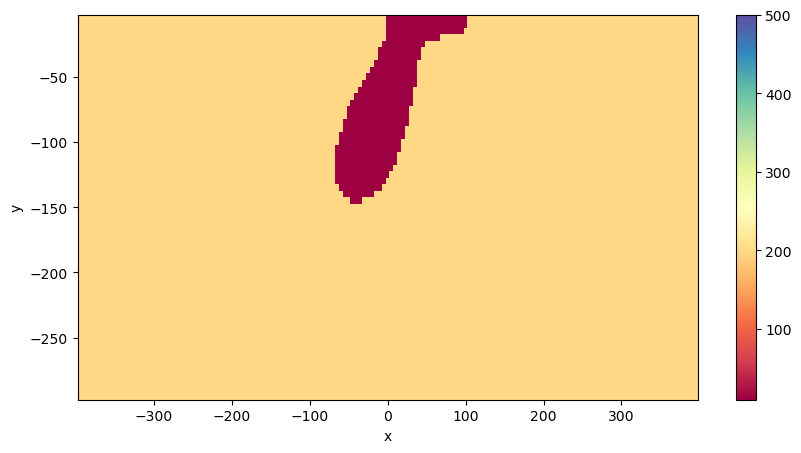

In [5]:
# masks[5]['area']
# bbox.shape
geological_model = segmentor.predict(dip_model)
fig, ax = plt.subplots(1,1, figsize=(10, 5))
dat = meshCore.plotImage(1 / np.exp(geological_model), ax=ax, clim=[10, 500], pcolorOpts={'cmap':"Spectral"})

plt.colorbar(dat[0])

/tmp/ipykernel_167470/882266561.py:5: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(1 / np.exp(dip_model), ax=ax[0, 1], clim=[10, 500], pcolorOpts={'cmap':"Spectral"})
/home/juanito/mambaforge/envs/jresearch/lib/python3.11/site-packages/discretize/utils/code_utils.py:313: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)
/tmp/ipykernel_167470/882266561.py:10: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax[0, 0], pcolorOpts={'cmap':"Spectral"})
/tmp/ipykernel_167470/882266561.py:13: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(1 

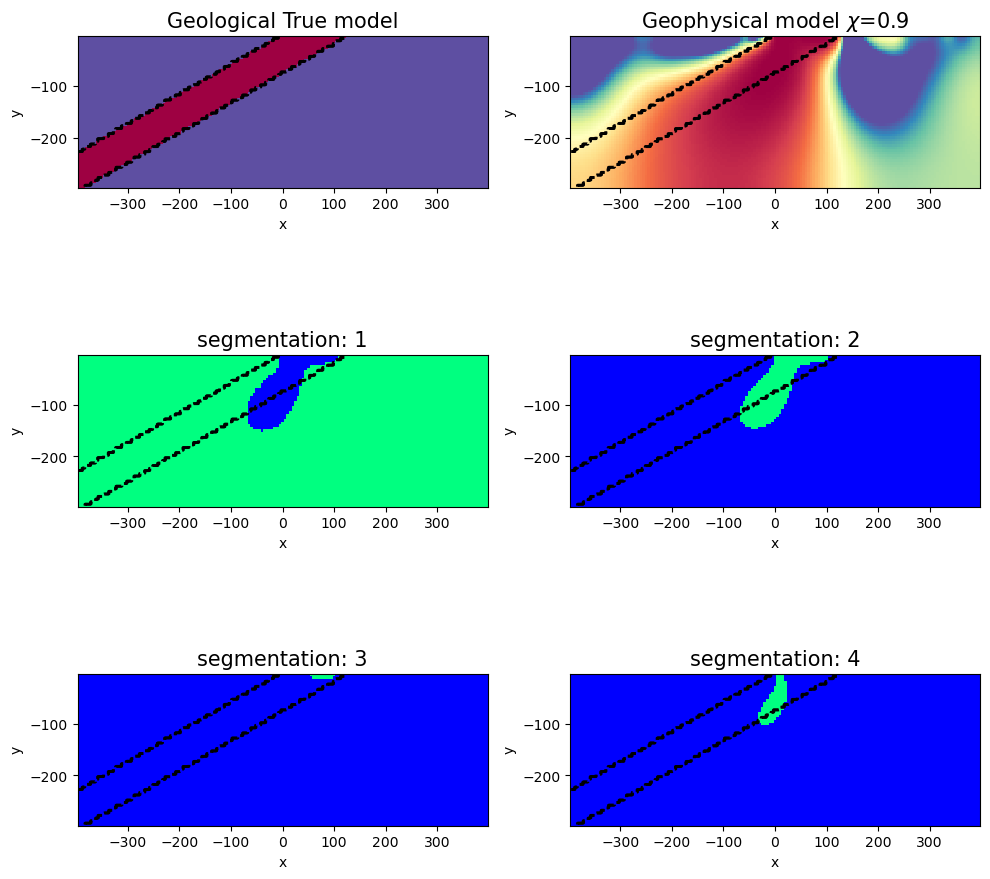

In [11]:
sam_model = segmentor
cond_true = mtrue
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

dat = meshCore.plotImage(1 / np.exp(dip_model), ax=ax[0, 1], clim=[10, 500], pcolorOpts={'cmap':"Spectral"})

ax[0, 1].set_title(r'Geophysical model $\chi$=0.9',fontsize=15)

flatten = (cond_true)[actcore]
dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax[0, 0], pcolorOpts={'cmap':"Spectral"})
ax[0, 0].set_title('Geological True model',fontsize=15)
flatten = sam_model.segmentations[0]['segmentation'].flatten(order='F')
dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax[1, 0], pcolorOpts={'cmap':"winter_r"})
ax[1, 0].set_title('segmentation: 1',fontsize=15)
flatten = sam_model.segmentations[1]['segmentation'].flatten(order='F')
dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax[1, 1], pcolorOpts={'cmap':"winter_r"})
# ax[1, 1].invert_yaxis()
ax[1, 1].set_title('segmentation: 2',fontsize=15)

flatten = sam_model.segmentations[2]['segmentation'].flatten(order='F')
dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax[2, 0], pcolorOpts={'cmap':"winter_r"})
# ax[1, 1].invert_yaxis()
ax[2, 0].set_title('segmentation: 3',fontsize=15)

flatten = sam_model.segmentations[3]['segmentation'].flatten(order='F')
dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax[2, 1], pcolorOpts={'cmap':"winter_r"})
# ax[1, 1].invert_yaxis()
ax[2, 1].set_title('segmentation: 4',fontsize=15)

# flatten = sam_model.masks[4]['segmentation'].flatten(order='F')
# dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax[3, 0], pcolorOpts={'cmap':"winter_r"})
# # ax[1, 1].invert_yaxis()
# ax[3, 0].set_title('segmentation: 5',fontsize=15)
# ax[3, 1].axis('off')
utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[1, 1],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0, 1],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[1, 0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0, 0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[2, 0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[2, 1],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

plt.tight_layout()

# angles

In [15]:
seg_data = results[1]['segmentation']
seg_data = np.flip(seg_data)
# Find the coordinates of the object pixels
object_pixels = np.argwhere(seg_data == 1)

# Apply PPCA to determine orientation
if len(object_pixels) > 1:
    # Standardize the data
    scaler = StandardScaler()
    object_pixels_std = scaler.fit_transform(object_pixels)

    # Apply PPCA
    pca = PCA(n_components=2)
    pca.fit(object_pixels_std)

    # The first principal component (eigenvector) will represent the orientation
    orientation_vector = pca.components_[0]

    # Compute the angle of the orientation vector (in degrees)
    angle_degrees = np.arctan2(orientation_vector[1], orientation_vector[0]) * 180 / np.pi

    print(f"Orientation angle (degrees): {angle_degrees}")
    angle_radians = angle_degrees * np.pi / 180

Orientation angle (degrees): -135.0


# Bounding box

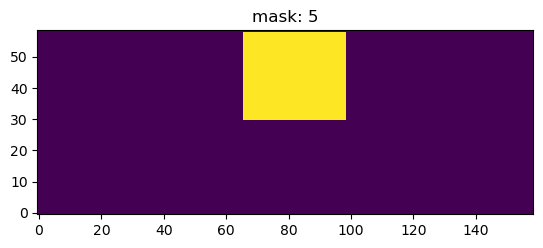

In [9]:
ii = 1
y0 = masks[ii]['bbox'][0]
x0 = masks[ii]['bbox'][1]
x1 = x0 + masks[ii]['bbox'][3]
y1 = y0 + masks[ii]['bbox'][2]

# generate as sparse matrix when things get big
bbox = np.zeros(masks[ii]['segmentation'].shape)

bbox[x0:x1, y0:y1] = 1
# bbox[x1, y1] = 1

flatten = bbox # masks[ii]['segmentation'].flatten(order='F')
reshape = flatten.reshape(meshCore.shape_cells, order='F')

plt.imshow(reshape.T)
plt.title(f'mask: {cnt}')
plt.gca().invert_yaxis()
# plt.plot([x0, x1], [y0, y1], 'ok')
plt.show()

/tmp/ipykernel_167470/2077487767.py:4: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax, pcolorOpts={'cmap':"winter_r"})
/home/juanito/mambaforge/envs/jresearch/lib/python3.11/site-packages/discretize/utils/code_utils.py:313: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)


(<matplotlib.contour.QuadContourSet at 0x717d2c596990>,
 <Axes: title={'center': 'Mask 4: Bounding box'}, xlabel='x', ylabel='y'>,
 <matplotlib.contour.QuadContourSet at 0x717d2c3dba90>)

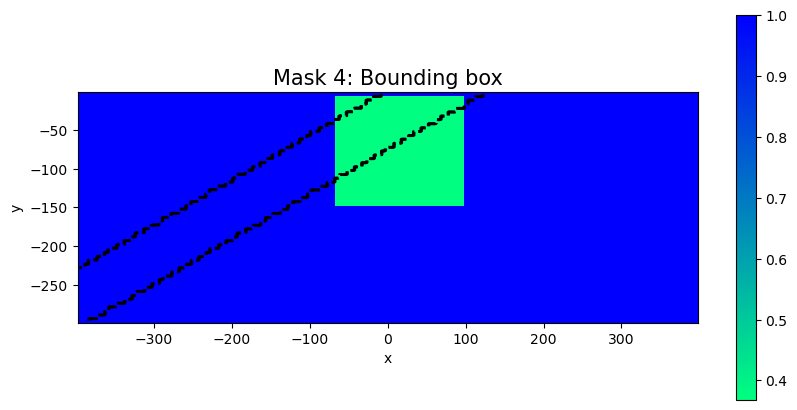

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
# dat = meshCore.plotImage(1 / np.exp(geological_model), ax=ax, clim=[10, 500], pcolorOpts={'cmap':"Spectral"})
flatten = reshape.flatten(order='F')  # (cond_true)[actcore]
dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax, pcolorOpts={'cmap':"winter_r"})
ax.set_title('Mask 4: Bounding box',fontsize=15)
plt.colorbar(dat[0])

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax,
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

In [18]:
np.save('rotation_block_mask.npy', flatten)

In [19]:
flatten.shape

(9381,)